In [239]:
%tensorflow_version 1.15
%matplotlib inline

import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import igraph
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from google.colab import drive

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [240]:
drive.mount('4107')

Drive already mounted at 4107; to attempt to forcibly remount, call drive.mount("4107", force_remount=True).


In [0]:
# load airfoil data
data = np.loadtxt('/content/4107/My Drive/4107/airfoil_self_noise.dat')

# split X,y
X, y = data[:, :5], data[:, 5]
y = y.reshape(y.shape[0], 1)

X = (X - X.min())/(X.max() - X.min())

In [0]:
# random split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y, test_size=0.5, random_state=43)

In [0]:
def cluster_split(labels):
  train_idx = []
  test_idx = []

  num_clusters = np.unique(labels)

  # randomly assign observations from each cluster to training/testing sets
  for cluster in num_clusters:
    mask = labels == cluster
    idx = [i for i in range(len(mask)) if mask[i]]

    # add all observations labelled as noise to training set
    if cluster == -1:
      train_idx += idx
    else:
      curr_train = random.sample(idx, int(0.5*len(idx)))
      train_idx += curr_train
      test_idx += [x for x in range(len(X)) if x not in curr_train and x in idx]

  return train_idx, test_idx

In [0]:
# K Means parameter
N_CLUSTERS = 5

# K Means clustering
km_clusters = KMeans(n_clusters=N_CLUSTERS, random_state=43).fit_predict(X)
km_train_idx, km_test_idx = cluster_split(km_clusters)

# split using K Means clusters
X_train_km, X_test_km, y_train_km, y_test_km = X[km_train_idx], X[km_test_idx], y[km_train_idx], y[km_test_idx]

In [0]:
# DBSCAN parameters
EPS = 0.05
MINPTS = 50

# DBSCAN clustering
db = DBSCAN(eps=EPS, min_samples=MINPTS).fit(X)
db_train_idx, db_test_idx = cluster_split(db.labels_)

# split using DBSCAN clusters
X_train_db, X_test_db, y_train_db, y_test_db = X[db_train_idx], X[db_test_idx], y[db_train_idx], y[db_test_idx]

In [0]:
# identify connections in graph using KNN
K_NEIGHBORS = 50
knn = NearestNeighbors(n_neighbors=K_NEIGHBORS).fit(X)
dist, idx = knn.kneighbors(X)

# generate graph
g = igraph.Graph()
g.add_vertices(X.shape[0])

# add edges
for i in range(X.shape[0]):
  adj = [(i, x) for x in idx[i] if x != i]
  g.add_edges(adj)

# remove multiple connections between same pair of verticies
g = g.simplify()

# cluster using the graph based greedy optimzation algorithm
fg_labels = np.array(g.community_fastgreedy().as_clustering().membership)
fg_train_idx, fg_test_idx = cluster_split(fg_labels)

# split using graph clusters
X_train_fg, X_test_fg, y_train_fg, y_test_fg = X[fg_train_idx], X[fg_test_idx], y[fg_train_idx], y[fg_test_idx]

In [0]:
def generate_model(lr, rho, num_h1):
  # input/output layers
  X = tf.placeholder(tf.float32, [None, 5])
  Y = tf.placeholder(tf.float32, [None, 1])

  # weights
  w1 = tf.Variable(tf.random_normal([5, num_h1]))
  w2 = tf.Variable(tf.random_normal([num_h1, 1]))

  # bias
  b1 = tf.Variable(tf.zeros([num_h1]))
  
  # configure network
  h1  = tf.nn.leaky_relu(tf.matmul(X, w1) + b1)
  out = tf.nn.leaky_relu(tf.matmul(h1, w2))

  cost = tf.losses.mean_squared_error(Y, out)
  opt  = tf.train.RMSPropOptimizer(lr, rho).minimize(cost)

  return X, Y, out, cost, opt

In [268]:
# hyperparameters
LR         = 0.0025
RHO        = 0.95 
NUM_H1     = 10
EPOCHS     = 100
BATCH_SIZE = 100

X_train_list = [X_train_rand, X_train_km, X_train_db, X_train_fg]
X_test_list = [X_test_rand, X_test_km, X_test_db, X_test_fg]
y_train_list = [y_train_rand, y_train_km, y_train_db, y_train_fg]
y_test_list = [y_test_rand, y_test_km, y_test_db, y_test_fg]

train_losses = []
test_losses = []

for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
  tf.reset_default_graph()

  curr_train_losses = []
  curr_test_losses = []

  with tf.Session() as sess:
    X_l, Y_l, out, cost, opt = generate_model(LR, RHO, NUM_H1)
    tf.global_variables_initializer().run()

    for epoch in range(EPOCHS):
      epoch_err = 0
      for x, y in zip(X_train, y_train):
        err, _ = sess.run((cost, opt), feed_dict={X_l: [x], Y_l: [y]})
        epoch_err += err
      epoch_err /= len(X_train)

      print('epoch {} MSE: {}'.format(epoch + 1, epoch_err))
      curr_train_losses.append(epoch_err)
      curr_test_losses.append(sess.run(cost, feed_dict={X_l: X_test, Y_l: y_test}))
    train_losses.append(curr_train_losses)
    test_losses.append(curr_test_losses)
      

epoch 1 MSE: 11654.365414798498
epoch 2 MSE: 2738.9350261769505
epoch 3 MSE: 301.160745138082
epoch 4 MSE: 227.29580445020162
epoch 5 MSE: 170.60738683288295
epoch 6 MSE: 124.70084149296862
epoch 7 MSE: 89.21068751462302
epoch 8 MSE: 64.15908592618786
epoch 9 MSE: 49.51828705842642
epoch 10 MSE: 43.428643525772394
epoch 11 MSE: 41.70103271366722
epoch 12 MSE: 41.39818595681348
epoch 13 MSE: 41.438339371476
epoch 14 MSE: 41.51876551562427
epoch 15 MSE: 41.57593620436504
epoch 16 MSE: 41.60642252956865
epoch 17 MSE: 41.61793821445084
epoch 18 MSE: 41.61759531751697
epoch 19 MSE: 41.61029785297653
epoch 20 MSE: 41.599008173272324
epoch 21 MSE: 41.585490662931804
epoch 22 MSE: 41.570708654599635
epoch 23 MSE: 41.55528196692172
epoch 24 MSE: 41.53947726304659
epoch 25 MSE: 41.523505266287835
epoch 26 MSE: 41.5074530434263
epoch 27 MSE: 41.4913535741783
epoch 28 MSE: 41.47527247576901
epoch 29 MSE: 41.45921790855425
epoch 30 MSE: 41.44318817872869
epoch 31 MSE: 41.42719190973202
epoch 32 MSE

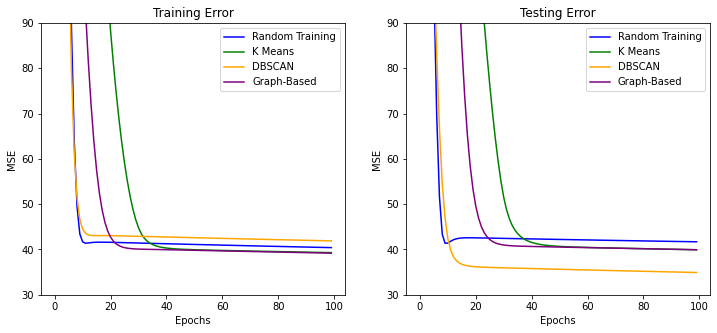

In [269]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

split = ['Random Training', 'K Means', 'DBSCAN', 'Graph-Based']
colors = ['b', 'g', 'orange', 'purple']
graph = ['Training Error', 'Testing Error']

for i in range(len(train_losses)):
  axes[0].plot(range(len(train_losses[i])), train_losses[i], label=split[i], color=colors[i])
  axes[1].plot(range(len(test_losses[i])), test_losses[i], label=split[i], color=colors[i])

for i, ax in enumerate(axes):
  ax.set(xlabel='Epochs', ylabel='MSE', title=graph[i])
  ax.legend()
  ax.set_ylim([30, 90])

#plt.savefig('optimal.png')
plt.show()

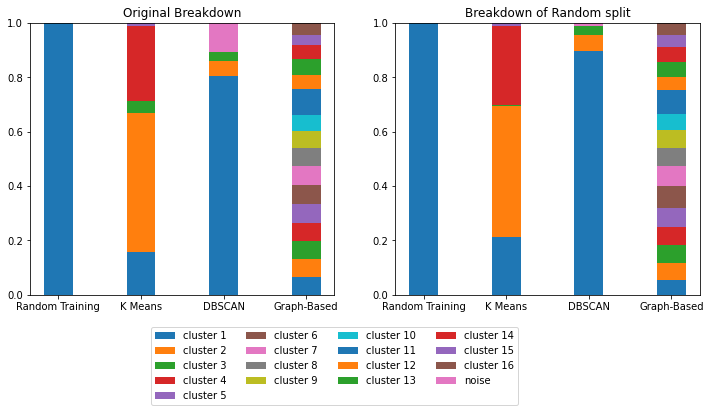

In [256]:
def membership(train_idx, labels, num_clusters, noise_cluster=False):
  member = {}
  
  for idx in train_idx:
    if labels[idx] in member:
      member[labels[idx]] += 1
    else:
      member[labels[idx]] = 1
  
  # build list of occurences, with 0 entries everywhere else
  occurences = sorted([(k,v) for k, v in member.items()], key=lambda x: x[0])
  occurences = [x[1] for x in occurences]
  occurences = [*occurences, *([0] * (num_clusters - len(occurences)))]
  occurences = [x/len(train_idx) for x in occurences]

  if noise_cluster:
    occurences.append(occurences.pop(0))
    occurences.insert(-2, 0)
  else:
    occurences.append(0)

  return occurences

# maxinum number of clusters
num_clusters = np.max([len(np.unique(km_clusters)), len(np.unique(db.labels_)), len(np.unique(fg_labels))])

# break up training samples into respective clusters
rand_member = [1] + [0] * (num_clusters)
km_member = membership(km_train_idx, km_clusters, num_clusters)
db_member = membership(db_train_idx, db.labels_, num_clusters, noise_cluster=True)
fg_member = membership(fg_train_idx, fg_labels, num_clusters)

# list of clusters for plot
tot_clusters = np.array([[w, x, y, z] for w, x, y, z in zip(rand_member, km_member, db_member, fg_member)])

# generate bar graph
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
axes2[0].bar(split, tot_clusters[0], 0.35, label='cluster 1')

# add stacks
for i in range(1, len(tot_clusters)):
  label = 'cluster {}'.format(i + 1) if i != len(tot_clusters) - 1 else 'noise'
  axes2[0].bar(split, tot_clusters[i], 0.35, bottom=np.sum(tot_clusters[:i], axis=0), label=label)

# adjust for legend
fig.subplots_adjust(bottom=0.15, wspace=0.15)
axes2[0].legend(loc='upper center', bbox_to_anchor=(1.0, -0.1), ncol=4)
axes2[0].set(title='Original Breakdown')

# training indices for random split
rand_train_idx = [i for i in range(len(X)) for j in range(len(X_train_rand)) if (X[i] == X_train_rand[j]).all()]

rand_km = membership(rand_train_idx, km_clusters, num_clusters)
rand_db = membership(rand_train_idx, db.labels_, num_clusters, noise_cluster=True)
rand_fg = membership(rand_train_idx, fg_labels, num_clusters)

# list of clusters for plot
rand_clusters = np.array([[w, x, y, z] for w, x, y, z in zip(rand_member, rand_km, rand_db, rand_fg)])

# generate bar graph
axes2[1].bar(split, rand_clusters[0], 0.35)

# add stacks
for i in range(1, len(rand_clusters)):
  axes2[1].bar(split, rand_clusters[i], 0.35, bottom=np.sum(rand_clusters[:i], axis=0))

axes2[1].set(title='Breakdown of Random split')

#plt.savefig('breakdown.png')
plt.show()